In [1]:
import torch
import torch.nn as nn
import sys

sys.path.append('../Natural Language Processing/')

from NLP_utils import *
import matplotlib.pyplot as plt
import time
from torchsummary import summary

# LSTM
## One LSTM Cell -
$$\tilde c^{<t>} = \tanh(W_c[a^{<t-1>}, x^{<t>}]+b_c)$$
$$\Gamma_u = \sigma(W_u[a^{<t-1>}, x^{<t>}]+b_u)$$
$$\Gamma_f = \sigma(W_f[a^{<t-1>}, x^{<t>}]+b_f)$$
$$\Gamma_o = \sigma(W_o[a^{<t-1>}, x^{<t>}]+b_o)$$
$$c^{<t>} = \Gamma_u * \tilde c^{<t>} + \Gamma_f * c^{<t-1>}$$
$$a^{<t>} = \Gamma_o * \tanh(c^{<t>})$$

WHERE -
- $t$ = Time-step number
- $h^{<t>}$ = Current Hidden State
- $h^{<t-1>}$ = Previous Hidden State
- $c^{<t>}$ = Current Cell State
- $c^{<t-1>}$ = Previous Cell State

- **$\tilde c^{<t>}$: Candidate vector** of $t^{th}$ LSTM Block
- $\Gamma_u$: **Update Gate**
    - Ranges from 0 to 1
    - Decides how much of the candidate will be UPDATED to the **current cell state $c^{t}$**
- $\Gamma_f$: **Forget Gate**
    - Ranges from 0 to 1
    - Decides how much of the previous cell state will be FORGOTTEN from the **current cell state $c^{t}$**
- $\Gamma_o$: **Output Gate**
    - Ranges from 0 to 1
    - Decides how much of the current cell state will play a role in the calculation of the **current hidden state $a^{t}$**

In [2]:
class LSTM(nn.Module):
    # Can use nn.GRU, but will do from scratch
    def __init__(self, input_size, hidden_size, output_size) -> None:
        super(LSTM, self).__init__() # Calling the super class __init__ function

        self.hidden_size = hidden_size
        
        self.candidate = nn.Linear(input_size+hidden_size, hidden_size)
        self.gamma_u = nn.Linear(input_size+hidden_size, hidden_size)
        self.gamma_f = nn.Linear(input_size+hidden_size, hidden_size)
        self.gamma_o = nn.Linear(input_size+hidden_size, hidden_size)

        self.hid2out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1) # Input = (1,57) so will need to use the second dimension, hence dim = 1
    
    def forward(self, xt, a_prev, c_prev): # One cell forward pass
        combined = torch.cat((xt, a_prev), 1) # Concat along dimension 1

        candidate = torch.tanh(self.candidate(combined))
        update_gate = torch.sigmoid(self.gamma_u(combined))
        forget_gate = torch.sigmoid(self.gamma_f(combined))
        output_gate = torch.sigmoid(self.gamma_o(combined))
        
        c_next = update_gate * candidate + forget_gate * c_prev
        a_next = output_gate * torch.tanh(c_next)

        yt = self.softmax(self.hid2out(a_next))
        return(yt, a_next, c_next)
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)
    
    def init_cell(self):
        return torch.zeros(1, self.hidden_size)

In [3]:
category_lines, all_categories = load_data()

# Number of categories -
# (Number of different languages .txt files we have)
n_categories = len(all_categories)
print(n_categories)

18


In [4]:
n_hidden = 256 # Hyperparameter we can set (Size of hidden state)

In [5]:
lstm = LSTM(N_LETTERS, n_hidden, n_categories)

In [7]:
# One step through the RNN cell
input_tensor = letter_to_tensor('A')
hidden_tensor = lstm.init_hidden() # Vector of zeros
cell_tensor = lstm.init_cell() # Vector of zeros

In [9]:
output, next_hidden, next_cell = lstm(input_tensor, hidden_tensor, cell_tensor)

In [10]:
print(output)

tensor([[-2.8348, -2.8837, -2.9247, -2.8694, -2.8911, -2.8425, -2.8630, -2.8312,
         -2.9159, -2.8532, -2.9099, -2.9333, -2.9478, -2.8958, -2.8538, -2.9292,
         -2.8978, -2.9630]], grad_fn=<LogSoftmaxBackward0>)


In [11]:
print(output.size()) # Number of categories
print(next_hidden.size()) # Hidden size
print(next_cell.size()) # Cell state size

torch.Size([1, 18])
torch.Size([1, 256])
torch.Size([1, 256])


# Prediction Trial

In [15]:
input_tensor1 = line_to_tensor('Albert')
hidden_tensor1 = lstm.init_hidden()
cell_tensor1 = lstm.init_cell()

In [16]:
input_tensor1.shape # (Number of letters, 1, Number of total possible ASCII characters = 57)

torch.Size([6, 1, 57])

In [17]:
output, next_hidden, next_cell = lstm(input_tensor1[0], hidden_tensor1, cell_tensor1)
print(output.size())
print(next_hidden.size())
print(next_cell.size())
# print(output)
# print(next_hidden)
# print(next_cell)

torch.Size([1, 18])
torch.Size([1, 256])
torch.Size([1, 256])


In [18]:
torch.argmax(output)

tensor(7)

In [19]:
def category_from_output(output):
    idx = torch.argmax(output).item()
    return all_categories[idx] # Returns the respective language

In [20]:
print(category_from_output(output)) # Its untrained hence it prints any random language

French


# Training

In [21]:
criterion = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(lstm.parameters(), lr = learning_rate)

In [22]:
def train(line_tensor, category_tensor):
    """
        line_tensor: Whole line as a tensor of one_hot encoded letters
        category_tensor: index of the class label in one-hot encoded form of shape - [1, n_categories] (n_categories = 18 here)
    """
    hidden = lstm.init_hidden()
    cell = lstm.init_cell()

    for i in range(line_tensor.shape[0]):
        output, hidden, cell = lstm(line_tensor[i], hidden, cell)

    loss = criterion(output, category_tensor)
    optimizer.zero_grad()
    with torch.autograd.set_detect_anomaly(True):
        loss.backward()
    optimizer.step()

    return output, loss.item() # Loss as float value

In [23]:
current_loss = 0
all_losses = []

# After 1000 steps - plot
# After 5000 steps - print
plot_steps, print_steps = 1000, 5000 
n_iters = 100000

In [24]:
tic = time.time()
for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines = category_lines, all_categories = all_categories)
    output, loss = train(line_tensor, category_tensor) # One iteration of training
    current_loss+=loss

    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0
    
    if (i+1) % print_steps == 0:
        prediction = category_from_output(output)
        # category = true category label
        # Basically we do a single prediction every 5000 steps (= print_steps)
        correct = "CORRECT!" if prediction == category else f'WRONG! ({category})'
        print(f'Epoch {i+1}; {(i+1)/n_iters * 100:.0f}% complete; Loss = {loss:.4f}; {line} / {prediction} {correct}')
print(f'Finished Training in {(time.time()-tic)//60:.0f}m {(time.time()-tic)%60:.0f}s')

Epoch 5000; 5% complete; Loss = 2.9007; Abadi / German WRONG! (Arabic)
Epoch 10000; 10% complete; Loss = 2.8613; Irie / German WRONG! (Japanese)
Epoch 15000; 15% complete; Loss = 2.7774; Gallego / Spanish CORRECT!
Epoch 20000; 20% complete; Loss = 2.6045; Metrofanis / Greek CORRECT!
Epoch 25000; 25% complete; Loss = 2.7084; Vedenkov / Russian CORRECT!
Epoch 30000; 30% complete; Loss = 2.2466; Van / Vietnamese CORRECT!
Epoch 35000; 35% complete; Loss = 2.0757; Tseluiko / Polish WRONG! (Russian)
Epoch 40000; 40% complete; Loss = 1.4270; Son / Korean CORRECT!
Epoch 45000; 45% complete; Loss = 2.3406; Mendes / Dutch WRONG! (Portuguese)
Epoch 50000; 50% complete; Loss = 1.7841; Johnston / Irish WRONG! (Scottish)
Epoch 55000; 55% complete; Loss = 3.8258; Minobe / French WRONG! (Japanese)
Epoch 60000; 60% complete; Loss = 0.9523; Habichev / Russian CORRECT!
Epoch 65000; 65% complete; Loss = 2.0713; Sarraf / Portuguese WRONG! (Arabic)
Epoch 70000; 70% complete; Loss = 0.8274; Kerper / German C

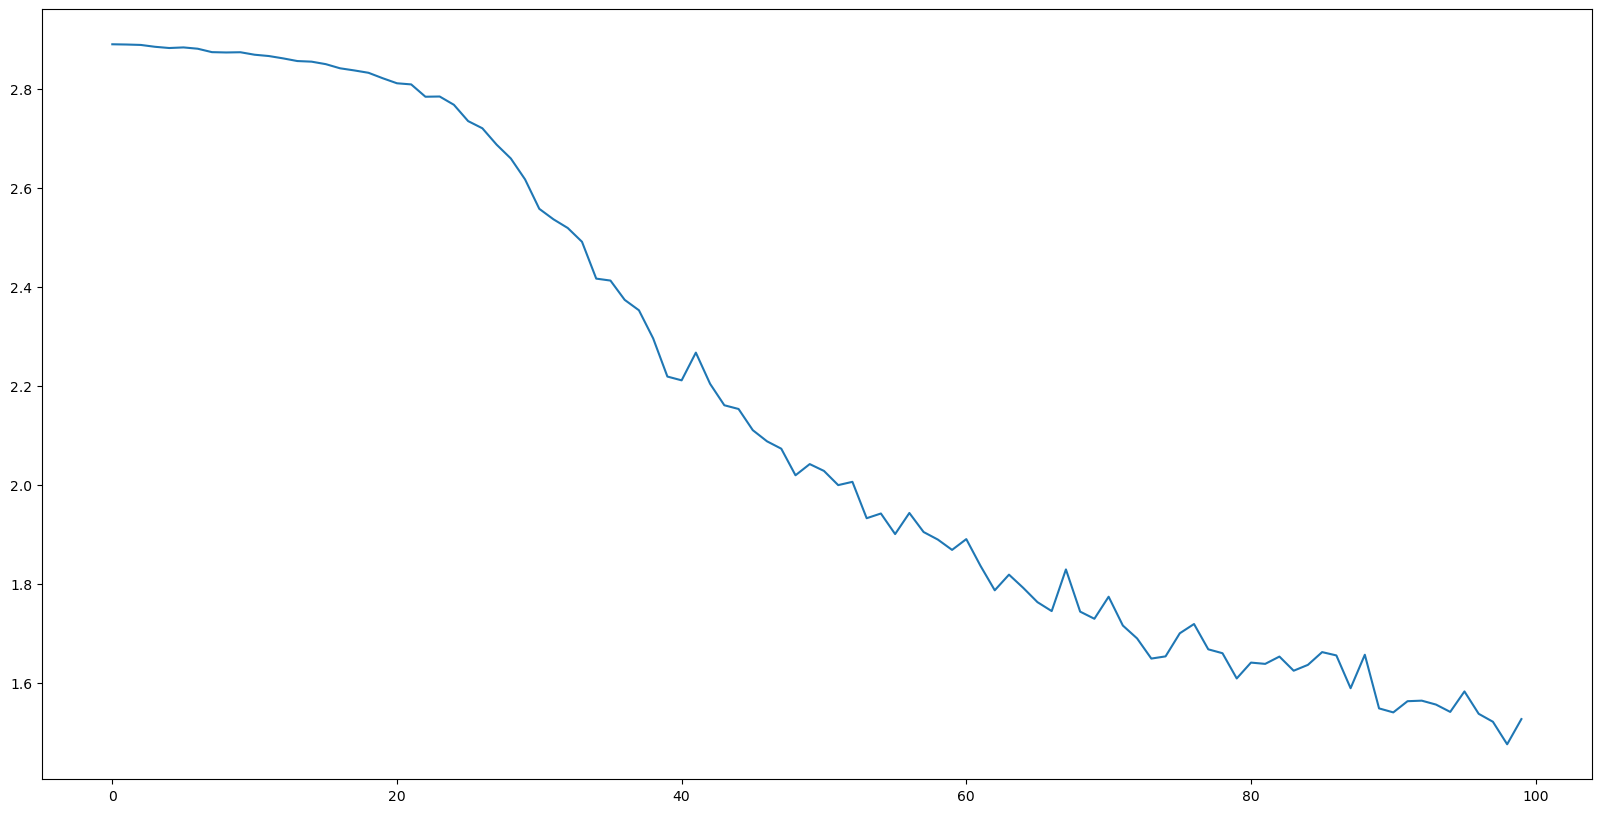

In [25]:
plt.figure(figsize = (20,10))
plt.plot(all_losses)
plt.show()

In [28]:
def predict(input_line):
    print(f'\n> {input_line}')
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        hidden = lstm.init_hidden()
        cell = lstm.init_cell()

        for i in range(line_tensor.shape[0] - 1):
            _, hidden, cell = lstm(line_tensor[i], hidden, cell)

        output, hidden, cell = lstm(line_tensor[i+1], hidden, cell)
        prediction = category_from_output(output)
        print('Prediction:', prediction)

In [29]:
while True:
    sentence = input("INPUT: ")
    if sentence == 'quit':
        break
    predict(sentence)


> Bao
Prediction: Vietnamese

> O'connor
Prediction: Scottish

> Gerard
Prediction: German

> Mahmood
Prediction: Arabic

> Polish
Prediction: English

> Richman
Prediction: Scottish

> Abel
Prediction: German

> Abl
Prediction: German
